# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Import modules

In [77]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,cross_validate,cross_val_predict,validation_curve
#from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_auc_score, roc_curve,confusion_matrix,precision_recall_curve,recall_score,precision_score,accuracy_score,f1_score,classification_report,make_scorer
from datetime import datetime
import pickle
import warnings
warnings.filterwarnings("ignore")
#% matplotlib inline

In [78]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Exploration Data Analysis

# Portfolio

In [79]:
portfolio.head(5)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [80]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [81]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [82]:
portfolio.offer_type.value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

In [83]:
new_portfolio = portfolio[["id","reward","difficulty","duration","offer_type"]]
new_portfolio.head(5)

,id,reward,difficulty,duration,offer_type
0,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,bogo
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,bogo
2,3f207df678b143eea3cee63160fa8bed,0,0,4,informational
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,bogo
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,discount


# Profile

In [84]:
profile.head(5)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [85]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [86]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [87]:
profile['became_member_year'] = profile['became_member_on'].apply(lambda x : int(str(x)[:4]))
profile.head(5)

,age,became_member_on,gender,id,income,became_member_year
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN,2017


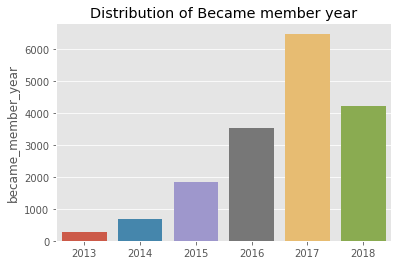

In [88]:
# Visualize distribution of Became member year
year_group = profile['became_member_year'].value_counts()
sns.barplot(year_group.index, year_group)
plt.title('Distribution of Became member year')
plt.show()

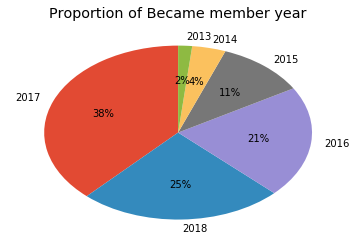

In [161]:
# Visualize proportion of Became member year
plt.pie(year_group, labels=year_group.index, autopct = '%0.0f%%',startangle = 90)
plt.title('Proportion of Became member year')
plt.show()

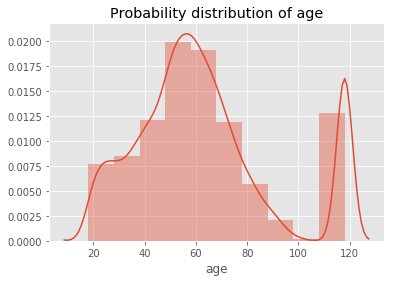

In [90]:
# Visulize probability distribution of age
sns.distplot(profile.age, bins = 10, kde=True)
plt.title('Probability distribution of age')
plt.show()

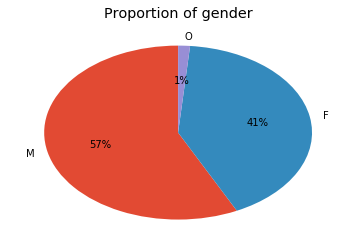

In [91]:
# Visualize proportion of gender
gender_counts = profile['gender'].value_counts()
plt.pie(gender_counts, labels=gender_counts.index, autopct = '%0.0f%%',startangle = 90)
plt.title('Proportion of gender')
plt.show()

In [92]:
new_profile = profile[["gender","age","id","income","became_member_year"]]
new_profile.head(5)

,gender,age,id,income,became_member_year
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017
4,None,118,a03223e636434f42ac4c3df47e8bac43,NaN,2017


# Transcript

In [93]:
transcript.head(5)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [94]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [95]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [96]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

# Data processing

In [97]:
# Data processing for transcript
def offer_separate_fun(x):
    if x.get("offer id"):
        return x['offer id']

    elif x.get("offer_id"):
        return x['offer_id']
    else:
        return np.nan


def amount_separate_fun(x):
    if x.get("amount"):
        return x['amount']
    else:
        return 0

def days_cal_fun(x):
    days = int(x / 24) + (x % 24 > 0)
    return days

In [98]:
# Separate columns for transcript
transcript['offer_id'] = transcript.value.apply(lambda x : offer_separate_fun(x))
transcript['amount'] = transcript.value.apply(lambda x : amount_separate_fun(x))
transcript['days'] = transcript.time.apply(lambda x : days_cal_fun(x))
transcript.head(5)

,event,person,time,value,offer_id,amount,days
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,0.0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,0.0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0


In [99]:
# Sampling
transcript[transcript.person =="0009655768c64bdeb2e877511632db8f"].head(5)

,event,person,time,value,offer_id,amount,days
55972,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},5a8bc65990b245e5a138643cd4eb9837,0.00,7
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},5a8bc65990b245e5a138643cd4eb9837,0.00,8
89291,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},NaN,22.16,10
113605,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed,0.00,14
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed,0.00,16


In [100]:
# Merge transcript and profile with id
df_trans_prof = transcript.merge(profile, how="outer",left_on='person',right_on='id')
df_trans_prof.head(5)

,event,person,time,value,offer_id,amount,days,age,became_member_on,gender,id,income,became_member_year
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,0,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,1,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,{'amount': 19.89},NaN,19.89,6,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017
3,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,6,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,{'amount': 17.78},NaN,17.78,6,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017


In [101]:
# Merge transcipt & profile dataset and portfolio data with the offer_id
df_trans_prof_port = df_trans_prof.merge(portfolio, how="outer",left_on='offer_id',right_on='id')
df_trans_prof_port.head(5)

,event,person,time,value,offer_id,amount,days,age,became_member_on,gender,id_x,income,became_member_year,channels,difficulty,duration,id_y,offer_type,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,"[web, email, mobile]",5.0,7.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,1,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,"[web, email, mobile]",5.0,7.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0
2,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,6,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,"[web, email, mobile]",5.0,7.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0
3,offer received,e2127556f4f64592b11af22de27a7932,408,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,17,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,2018,"[web, email, mobile]",5.0,7.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0
4,offer viewed,e2127556f4f64592b11af22de27a7932,420,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,18,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,2018,"[web, email, mobile]",5.0,7.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0


In [102]:
# Drop duplicated columns
df_trans_prof_port.drop(columns=['value','time',"id_x",'became_member_on',"channels","id_y"],inplace=True)
df_trans_prof_port.head(5)

,event,person,offer_id,amount,days,age,gender,income,became_member_year,difficulty,duration,offer_type,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0,75,F,100000.0,2017,5.0,7.0,bogo,5.0
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,1,75,F,100000.0,2017,5.0,7.0,bogo,5.0
2,offer completed,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,6,75,F,100000.0,2017,5.0,7.0,bogo,5.0
3,offer received,e2127556f4f64592b11af22de27a7932,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,17,68,M,70000.0,2018,5.0,7.0,bogo,5.0
4,offer viewed,e2127556f4f64592b11af22de27a7932,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,18,68,M,70000.0,2018,5.0,7.0,bogo,5.0


In [103]:
df_trans_prof_port.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 13 columns):
event                 306534 non-null object
person                306534 non-null object
offer_id              167581 non-null object
amount                306534 non-null float64
days                  306534 non-null int64
age                   306534 non-null int64
gender                272762 non-null object
income                272762 non-null float64
became_member_year    306534 non-null int64
difficulty            167581 non-null float64
duration              167581 non-null float64
offer_type            167581 non-null object
reward                167581 non-null float64
dtypes: float64(5), int64(3), object(5)
memory usage: 32.7+ MB


In [104]:
# Split dataframe with null and not null
df_trans_prof_null = df_trans_prof.loc[df_trans_prof.gender.isnull(),:]
df_trans_prof_notnull = df_trans_prof.loc[df_trans_prof.gender.notnull(),:]

In [105]:
# Base on the null value for gender and income, deep dive into it.
completed_received_rate_null = len(df_trans_prof_null.loc[(df_trans_prof_null.event == 'offer completed'),:]) / len(df_trans_prof_null.loc[(df_trans_prof_null.event == 'offer received'),:])
completed_received_rate_notnull = len(df_trans_prof_notnull.loc[(df_trans_prof_notnull.event == 'offer completed'),:]) / len(df_trans_prof_notnull.loc[(df_trans_prof_notnull.event == 'offer received'),:])
df_completed_received_rate = pd.DataFrame({
    'category' : ['gender_null','gender_notnull'],
    'rate' : [completed_received_rate_null,completed_received_rate_notnull]
}
)
df_completed_received_rate

,category,rate
0,gender_null,0.116101
1,gender_notnull,0.487872


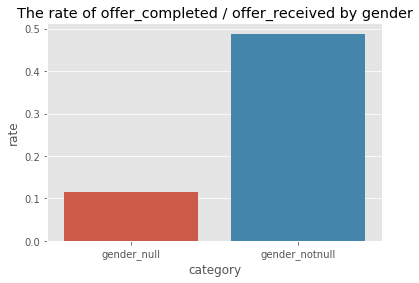

In [106]:
# Visualize rate of of offer_completed / offer_received by gender
sns.barplot(df_completed_received_rate.category,df_completed_received_rate.rate)
plt.title("The rate of offer_completed / offer_received by gender")
plt.show()

In [107]:
# Filter offer completed
df_offer_completed = df_trans_prof_port.loc[df_trans_prof_port.event == 'offer completed',:]
df_offer_completed.head(5)

,event,person,offer_id,amount,days,age,gender,income,became_member_year,difficulty,duration,offer_type,reward
2,offer completed,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,6,75,F,100000.0,2017,5.0,7.0,bogo,5.0
5,offer completed,e2127556f4f64592b11af22de27a7932,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,22,68,M,70000.0,2018,5.0,7.0,bogo,5.0
12,offer completed,389bc3fa690240e798340f5a15918d5c,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,21,65,M,53000.0,2018,5.0,7.0,bogo,5.0
23,offer completed,868317b9be554cb18e50bc68484749a2,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,20,96,F,89000.0,2017,5.0,7.0,bogo,5.0
25,offer completed,f082d80f0aac47a99173ba8ef8fc1909,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,1,40,M,33000.0,2016,5.0,7.0,bogo,5.0


In [108]:
df_offer_completed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33579 entries, 2 to 306533
Data columns (total 13 columns):
event                 33579 non-null object
person                33579 non-null object
offer_id              33579 non-null object
amount                33579 non-null float64
days                  33579 non-null int64
age                   33579 non-null int64
gender                32444 non-null object
income                32444 non-null float64
became_member_year    33579 non-null int64
difficulty            33579 non-null float64
duration              33579 non-null float64
offer_type            33579 non-null object
reward                33579 non-null float64
dtypes: float64(5), int64(3), object(5)
memory usage: 3.6+ MB


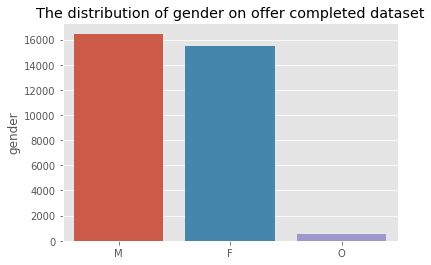

In [109]:
# Visualize distribution of gender on offer completed dataset
gender_count = df_offer_completed['gender'].value_counts()
sns.barplot(gender_count.index,gender_count)
plt.title("The distribution of gender on offer completed dataset")
plt.show()

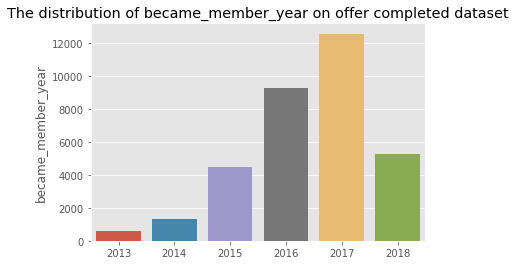

In [110]:
# Visualize distribution of became_member_year on offer completed dataset
became_member_count = df_offer_completed['became_member_year'].value_counts()
sns.barplot(became_member_count.index,became_member_count)
plt.title("The distribution of became_member_year on offer completed dataset")
plt.show()

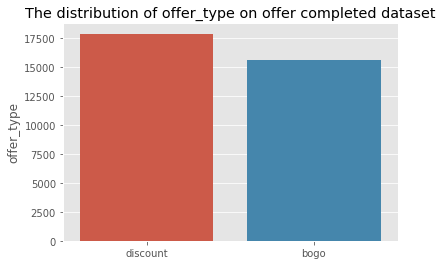

In [111]:
# Visualize distribution of offer_type on offer completed dataset
offer_type_count = df_offer_completed['offer_type'].value_counts()
sns.barplot(offer_type_count.index,offer_type_count)
plt.title("The distribution of offer_type on offer completed dataset")
plt.show()

# Filter target dataset

In [112]:
# Filter tager datasets for further AI modeling
df_target = df_trans_prof_port.loc[((df_trans_prof_port.gender.notnull()) & (df_trans_prof_port.offer_type.isin(['bogo','discount']))),:]
df_target.shape

(126145, 13)

In [113]:
df_target.head(5)

,event,person,offer_id,amount,days,age,gender,income,became_member_year,difficulty,duration,offer_type,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0,75,F,100000.0,2017,5.0,7.0,bogo,5.0
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,1,75,F,100000.0,2017,5.0,7.0,bogo,5.0
2,offer completed,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,6,75,F,100000.0,2017,5.0,7.0,bogo,5.0
3,offer received,e2127556f4f64592b11af22de27a7932,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,17,68,M,70000.0,2018,5.0,7.0,bogo,5.0
4,offer viewed,e2127556f4f64592b11af22de27a7932,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,18,68,M,70000.0,2018,5.0,7.0,bogo,5.0


In [114]:
df_target['flag'] = 1
df_target_groupby = df_target.groupby(['person', 'offer_id','event'],as_index=True)['flag'].max().unstack(fill_value=0)
df_target_groupby

event                                                              offer completed  \
person                           offer_id                                            
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5                1   
                                 f19421c1d4aa40978ebb69ca19b0e20d                1   
                                 fafdcd668e3743c1bb461111dcafc2a4                1   
0011e0d4e6b944f998e987f904e8c1e5 0b1e1539f2cc45b7b9fa7c272da2e1d7                1   
                                 2298d6c36e964ae4a3e7e9706d1fb8c2                1   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9                1   
0020c2b971eb4e9188eac86d93036a77 4d5c57ea9a6940dd891ad53e9dbe8da0                1   
                                 ae264e3637204a6fb9bb56bc8210ddfd                0   
                                 fafdcd668e3743c1bb461111dcafc2a4                1   
0020ccbbb6d84e358d3414a3ff76cffd 2298d6c36e964ae4a3e7e9706d1fb8c2                1   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9                1   
                                 f19421c1d4aa40978ebb69ca19b0e20d                1   
003d66b6608740288d6cc97a6903f4f0 0b1e1539f2cc45b7b9fa7c272da2e1d7                1   
                                 fafdcd668e3743c1bb461111dcafc2a4                1   
00426fe3ffde4c6b9cb9ad6d077a13ea 0b1e1539f2cc45b7b9fa7c272da2e1d7                0   
                                 2906b810c7d4411798c6938adc9daaa5                0   
                                 fafdcd668e3743c1bb461111dcafc2a4                1   
004b041fbfe44859945daa2c7f79ee64 f19421c1d4aa40978ebb69ca19b0e20d                1   
                                 fafdcd668e3743c1bb461111dcafc2a4                1   
004c5799adbf42868b9cff0396190900 ae264e3637204a6fb9bb56bc8210ddfd                1   
                                 f19421c1d4aa40978ebb69ca19b0e20d                1   
                                 fafdcd668e3743c1bb461111dcafc2a4                1   
005500a7188546ff8a767329a2f7c76a 2906b810c7d4411798c6938adc9daaa5                0   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9                1   
                                 ae264e3637204a6fb9bb56bc8210ddfd                0   
0056df74b63b4298809f0b375a304cf4 0b1e1539f2cc45b7b9fa7c272da2e1d7                1   
                                 2298d6c36e964ae4a3e7e9706d1fb8c2                1   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9                1   
00715b6e55c3431cb56ff7307eb19675 0b1e1539f2cc45b7b9fa7c272da2e1d7                1   
                                 2906b810c7d4411798c6938adc9daaa5                1   
...                                                                            ...   
ffdefcac307f4ca99ac1ebd51470f106 9b98b8c7a33c4b65b9aebfe6a799e6d9                1   
                                 fafdcd668e3743c1bb461111dcafc2a4                1   
ffe5257abf8840b395e1ee6b29894637 0b1e1539f2cc45b7b9fa7c272da2e1d7                1   
                                 2906b810c7d4411798c6938adc9daaa5                1   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9                1   
                                 f19421c1d4aa40978ebb69ca19b0e20d                0   
ffeaa02452ef451082a0361c3ca62ef5 2906b810c7d4411798c6938adc9daaa5                1   
                                 ae264e3637204a6fb9bb56bc8210ddfd                1   
ffed75d3abc64b488982f50ed12878b5 4d5c57ea9a6940dd891ad53e9dbe8da0                0   
                                 ae264e3637204a6fb9bb56bc8210ddfd                0   
fff0f0aac6c547b9b263080f09a5586a 4d5c57ea9a6940dd891ad53e9dbe8da0                0   
fff29fb549084123bd046dbc5ceb4faa 4d5c57ea9a6940dd891ad53e9dbe8da0                1   
                                 ae264e3637204a6fb9bb56bc8210ddfd                1   
                                 f19421c1d4a

In [116]:
df_target_groupby.reset_index(inplace=True)
df_target_groupby.head(5)

event,index,person,offer_id,offer completed,offer received,offer viewed
0,0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,1,0
1,1,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1
2,2,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1
3,3,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,1
4,4,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1


# Labeling based on the logic that: once use received offer, viewed offer and completed offer then 1 else 0, 1 means use consumed offer 0 means does not consumed the offer. The target of the this project is verify the potenctial user who can consume the offer by AI modeling.

In [117]:
def get_labeling_fun(x):
    '''
    INPUT:
    x - (DataFrame) DataFrame of offer_received,offer_viewed and offer_completed
    
    OUTPUT:
    y - (int) A int value of labeling 
    '''
    if x["offer received"] ==1 & x['offer viewed'] == 1 & x["offer completed"] ==1:
        return 1
    else:
        return 0

In [118]:
#df_target_groupby['label'] = df_target_groupby[["person","offer_id","offer received","offer viewed","offer completed"]].apply(lambda x : get_labeling_fun(x),axis=1)
df_target_groupby['label'] = df_target_groupby.apply(lambda x : get_labeling_fun(x),axis=1)
df_target_groupby.head(5)

event,index,person,offer_id,offer completed,offer received,offer viewed,label
0,0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,1,0,0
1,1,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
2,2,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
3,3,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,1,1
4,4,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1


In [119]:
# Merge df_target_groupby and new_profile
target_profile = df_target_groupby.merge(new_profile,how="left",left_on="person",right_on="id")
df_data = target_profile.merge(new_portfolio,how="left",left_on="offer_id",right_on="id")
print(df_data.shape)
df_data.head(5)

(44181, 17)


,index,person,offer_id,offer completed,offer received,offer viewed,label,gender,age,id_x,income,became_member_year,id_y,reward,difficulty,duration,offer_type
0,0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,1,0,0,M,33,0009655768c64bdeb2e877511632db8f,72000.0,2017,2906b810c7d4411798c6938adc9daaa5,2,10,7,discount
1,1,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,M,33,0009655768c64bdeb2e877511632db8f,72000.0,2017,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,bogo
2,2,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,M,33,0009655768c64bdeb2e877511632db8f,72000.0,2017,fafdcd668e3743c1bb461111dcafc2a4,2,10,10,discount
3,3,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,1,1,O,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,2018,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,discount
4,4,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,O,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,2018,2298d6c36e964ae4a3e7e9706d1fb8c2,3,7,7,discount


In [120]:
# Drop duplicated columns
df_data.drop(columns = ["offer_id","offer completed","offer received","offer viewed","id_x","id_y"],inplace=True)
df_data.head(5)

,index,person,label,gender,age,income,became_member_year,reward,difficulty,duration,offer_type
0,0,0009655768c64bdeb2e877511632db8f,0,M,33,72000.0,2017,2,10,7,discount
1,1,0009655768c64bdeb2e877511632db8f,1,M,33,72000.0,2017,5,5,5,bogo
2,2,0009655768c64bdeb2e877511632db8f,1,M,33,72000.0,2017,2,10,10,discount
3,3,0011e0d4e6b944f998e987f904e8c1e5,1,O,40,57000.0,2018,5,20,10,discount
4,4,0011e0d4e6b944f998e987f904e8c1e5,1,O,40,57000.0,2018,3,7,7,discount


In [121]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44181 entries, 0 to 44180
Data columns (total 11 columns):
index                 44181 non-null int64
person                44181 non-null object
label                 44181 non-null int64
gender                44181 non-null object
age                   44181 non-null int64
income                44181 non-null float64
became_member_year    44181 non-null int64
reward                44181 non-null int64
difficulty            44181 non-null int64
duration              44181 non-null int64
offer_type            44181 non-null object
dtypes: float64(1), int64(7), object(3)
memory usage: 4.0+ MB


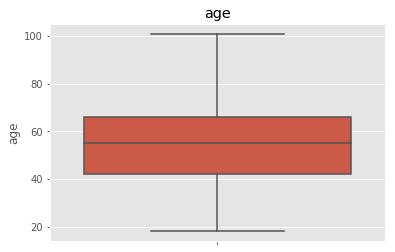

In [122]:
# Visualize boxplot for age
sns.boxplot(y=df_data['age'])
plt.title("age")
plt.show()

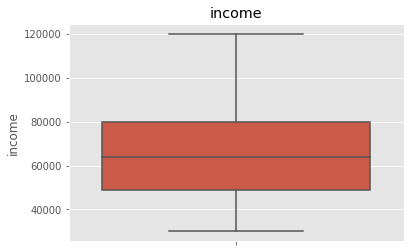

In [123]:
# Visualize boxplot for income
sns.boxplot(y=df_data['income'])
plt.title('income')
plt.show()

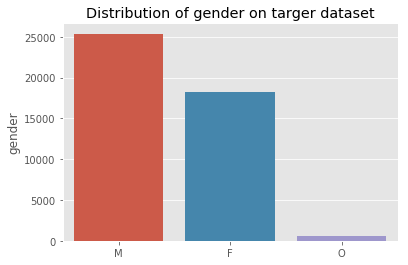

In [124]:
# Visualize distribution of gender on target dataset
gender_total = df_data['gender'].value_counts()
sns.barplot(gender_total.index,gender_total)
plt.title("Distribution of gender on targer dataset")
plt.show()

# Feature Engineering

In [125]:
# Onehot for category columns
df_data=df_data.join(pd.get_dummies(df_data["gender"],prefix="gender_",drop_first=True))
df_data=df_data.join(pd.get_dummies(df_data["offer_type"],prefix="offer_type_",drop_first=True))
df_data.head(5)

,index,person,label,gender,age,income,became_member_year,reward,difficulty,duration,offer_type,gender__M,gender__O,offer_type__discount
0,0,0009655768c64bdeb2e877511632db8f,0,M,33,72000.0,2017,2,10,7,discount,1,0,1
1,1,0009655768c64bdeb2e877511632db8f,1,M,33,72000.0,2017,5,5,5,bogo,1,0,0
2,2,0009655768c64bdeb2e877511632db8f,1,M,33,72000.0,2017,2,10,10,discount,1,0,1
3,3,0011e0d4e6b944f998e987f904e8c1e5,1,O,40,57000.0,2018,5,20,10,discount,0,1,1
4,4,0011e0d4e6b944f998e987f904e8c1e5,1,O,40,57000.0,2018,3,7,7,discount,0,1,1


In [126]:
# Drop columns
df_data.drop(columns = ["gender","offer_type"],inplace=True)
df_data.head(5)

,index,person,label,age,income,became_member_year,reward,difficulty,duration,gender__M,gender__O,offer_type__discount
0,0,0009655768c64bdeb2e877511632db8f,0,33,72000.0,2017,2,10,7,1,0,1
1,1,0009655768c64bdeb2e877511632db8f,1,33,72000.0,2017,5,5,5,1,0,0
2,2,0009655768c64bdeb2e877511632db8f,1,33,72000.0,2017,2,10,10,1,0,1
3,3,0011e0d4e6b944f998e987f904e8c1e5,1,40,57000.0,2018,5,20,10,0,1,1
4,4,0011e0d4e6b944f998e987f904e8c1e5,1,40,57000.0,2018,3,7,7,0,1,1


In [127]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44181 entries, 0 to 44180
Data columns (total 12 columns):
index                   44181 non-null int64
person                  44181 non-null object
label                   44181 non-null int64
age                     44181 non-null int64
income                  44181 non-null float64
became_member_year      44181 non-null int64
reward                  44181 non-null int64
difficulty              44181 non-null int64
duration                44181 non-null int64
gender__M               44181 non-null uint8
gender__O               44181 non-null uint8
offer_type__discount    44181 non-null uint8
dtypes: float64(1), int64(7), object(1), uint8(3)
memory usage: 4.7+ MB


In [128]:
# Convert the data type with int
df_data["gender__M"] = df_data["gender__M"].astype(int)
df_data["gender__O"] = df_data["gender__O"].astype(int)
df_data["offer_type__discount"] = df_data["offer_type__discount"].astype(int)

In [129]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44181 entries, 0 to 44180
Data columns (total 12 columns):
index                   44181 non-null int64
person                  44181 non-null object
label                   44181 non-null int64
age                     44181 non-null int64
income                  44181 non-null float64
became_member_year      44181 non-null int64
reward                  44181 non-null int64
difficulty              44181 non-null int64
duration                44181 non-null int64
gender__M               44181 non-null int64
gender__O               44181 non-null int64
offer_type__discount    44181 non-null int64
dtypes: float64(1), int64(10), object(1)
memory usage: 5.6+ MB


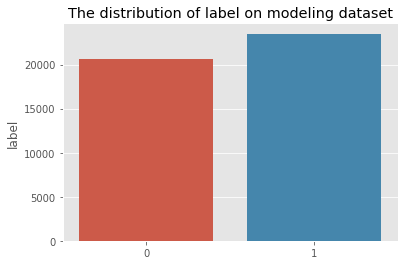

In [130]:
# Visualize distribution of lable on target dataset
label_count = df_data.label.value_counts()
sns.barplot(label_count.index,label_count)
plt.title("The distribution of label on modeling dataset")
plt.show()

# AI Modeling

In [131]:
# Split train & test datasets
df_label = df_data["label"]
df_data.drop(columns=['person'],inplace=True)
df_features = df_data.drop(columns= ['label'])
X_train,X_test,y_train,y_test = train_test_split(df_features,df_label,test_size=0.2,random_state=42)

In [132]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35344 entries, 4879 to 15795
Data columns (total 10 columns):
index                   35344 non-null int64
age                     35344 non-null int64
income                  35344 non-null float64
became_member_year      35344 non-null int64
reward                  35344 non-null int64
difficulty              35344 non-null int64
duration                35344 non-null int64
gender__M               35344 non-null int64
gender__O               35344 non-null int64
offer_type__discount    35344 non-null int64
dtypes: float64(1), int64(9)
memory usage: 3.0 MB


In [133]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8837 entries, 30059 to 538
Data columns (total 10 columns):
index                   8837 non-null int64
age                     8837 non-null int64
income                  8837 non-null float64
became_member_year      8837 non-null int64
reward                  8837 non-null int64
difficulty              8837 non-null int64
duration                8837 non-null int64
gender__M               8837 non-null int64
gender__O               8837 non-null int64
offer_type__discount    8837 non-null int64
dtypes: float64(1), int64(9)
memory usage: 759.4 KB


# Baseline AI model

In [134]:
# Fit LogistciRegression model
lr_model = LogisticRegression(random_state =42)
lr_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [135]:
y_train_pred_lr = lr_model.predict(X_train)
y_train_proba_lr = lr_model.predict_proba(X_train)[:,1]

y_test_pred_lr = lr_model.predict(X_test)
y_test_proba_lr = lr_model.predict_proba(X_test)[:,1]

In [136]:
print(classification_report(y_train,y_train_pred_lr))

             precision    recall  f1-score   support

          0       0.62      0.51      0.56     16523
          1       0.63      0.72      0.67     18821

avg / total       0.62      0.62      0.62     35344



In [138]:
# Hyperameter tuning
rfc_model = RandomForestClassifier(random_state =42)

# define parameter space to test # runtime 35min
params = {
        'max_depth': [4,5,6],
        'n_estimators': [5,10,20]
        }


grid_model = GridSearchCV(rfc_model, params, n_jobs=4, scoring="f1_macro")
grid_model.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'max_depth': [4, 5, 6], 'n_estimators': [5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_macro', verbose=0)

In [139]:
grid_model.best_params_

{'max_depth': 6, 'n_estimators': 20}

```python

```

# AI modeling with hyperameter 

In [140]:
model = RandomForestClassifier(n_estimators = 20, max_depth = 6,random_state =42)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [141]:
y_train_pred_rfc = model.predict(X_train)
y_train_proba_rfc = model.predict_proba(X_train)[:,1]

y_test_pred_rfc = model.predict(X_test)
y_test_proba_rfc = model.predict_proba(X_test)[:,1]

# Evaluation

In [142]:
print(classification_report(y_train,y_train_pred_rfc))

             precision    recall  f1-score   support

          0       0.69      0.61      0.65     16523
          1       0.69      0.76      0.72     18821

avg / total       0.69      0.69      0.69     35344



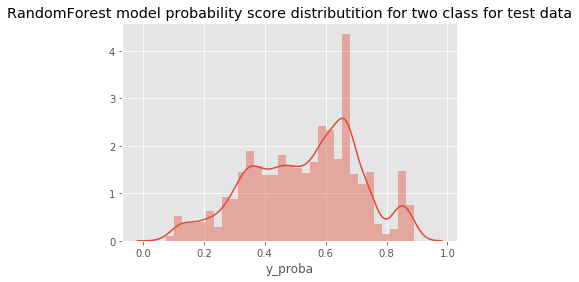

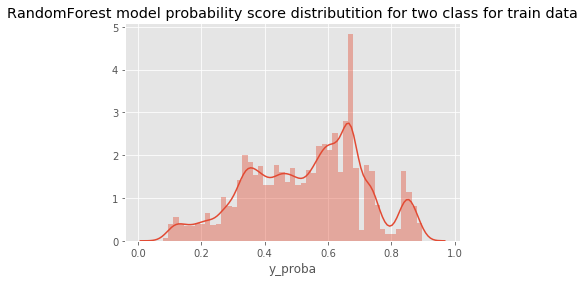

In [150]:
# Post Analysis
test_ys_rfc = pd.DataFrame({
    'y': y_test,
    'y_proba': y_test_proba_rfc
})
sns_plot = sns.distplot(test_ys_rfc.y_proba, kde=True)
plt.title('RandomForest model probability score distributition for two class for test data')
plt.show()

train_ys_rfc = pd.DataFrame({
    'y': y_train_pred_rfc,
    'y_proba': y_train_proba_rfc
})
sns_plot = sns.distplot(train_ys_rfc.y_proba, kde=True)
plt.title('RandomForest model probability score distributition for two class for train data')
plt.show()

In [151]:
def Post_Analysis_visualization(result,flag = None):
    sns_plot = sns.displot(result, x="y_proba", binwidth=0.05, hue="y", stat="probability", kde=True)
    plt.title('model probability score distributition for two class for %s data' %(flag))
    plt.show()
    plt.close()
    
def plot_confusion_matrix(y_true, y_predict, figure_name=None, model_name=None):
    name = 'Confusion Matrix'
    plt.rcParams['font.sans-serif'] = ['Microsoft Yahei']
    plt.rcParams['axes.unicode_minus'] = False
    cm = confusion_matrix(y_true, y_predict, labels=[0, 1])
    sns.heatmap(cm, fmt='.0f', cmap='GnBu', annot=True)
    # plt.title('Confusion Matrix - %s_Test' %(model_name))
    plt.xlabel('Predicted_Label')
    plt.ylabel('True_Label')
    plt.show()
    plt.close()
    
# TODO : ROC_Curve visualization
def plot_roc_curve_train_test(y_train, y_train_proba, y_test, y_test_proba, model_name=None, figure_name=None):
    plt.style.use("ggplot")
    plt.rcParams['font.sans-serif'] = ['Microsoft Yahei']
    plt.rcParams['axes.unicode_minus'] = False

    fpr_train, tpr_train, threshold_train = roc_curve(y_train, y_train_proba)
    fpr_test, tpr_test, threshold_test = roc_curve(y_test, y_test_proba)

    roc_auc_train = auc(fpr_train, tpr_train)
    roc_auc_test = auc(fpr_test, tpr_test)
    # plt.stackplot(fpr,tpr,color ='steelblue',edgecolor = 'black',alpha = 0.5)
    plt.plot(fpr_train, tpr_train, color='green', lw=1, label='Train AUC : %.3f' % (roc_auc_train))
    plt.plot(fpr_test, tpr_test, color='blue', lw=1, label='Test AUC : %.3f' % (roc_auc_test))
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')

    # plt.text(0.5,0.3,'roc curve (area : %.4f)' % roc_auc)
    plt.title('ROC Curve')
    # plt.xlabel('1-Specifity')
    plt.xlabel('False Positive Rate')
    # plt.ylabel('Sensitivity')
    plt.ylabel('True Positive Rate')
    plt.show()
    plt.close()
    
# TODO : ROC_Curve visualization
def plot_roc_curve(y_test, y_test_proba, model_name=None, figure_name=None):
    plt.style.use("ggplot")
    plt.rcParams['font.sans-serif'] = ['Microsoft Yahei']
    plt.rcParams['axes.unicode_minus'] = False

    fpr_test, tpr_test, threshold_test = roc_curve(y_test, y_test_proba)

    roc_auc_test = auc(fpr_test, tpr_test)
    # plt.stackplot(fpr,tpr,color ='steelblue',edgecolor = 'black',alpha = 0.5)
    plt.plot(fpr_test, tpr_test, color='blue', lw=1, label='Test AUC : %.3f' % (roc_auc_test))

    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')

    # plt.text(0.5,0.3,'roc curve (area : %.4f)' % roc_auc)
    plt.title('ROC Curve')
    # plt.xlabel('1-Specifity')
    plt.xlabel('False Positive Rate')
    # plt.ylabel('Sensitivity')
    plt.ylabel('True Positive Rate')
    plt.show()
    plt.close()

# TODO : PR_Curve visualization
def plot_precision_recall_train_test(y_train, y_train_proba, y_test, y_test_proba, model_name=None, figure_name=None):
    plt.style.use("ggplot")
    plt.rcParams['font.sans-serif'] = ['Microsoft Yahei']
    plt.rcParams['axes.unicode_minus'] = False

    precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, y_train_proba)
    precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, y_test_proba)
    pr_train = auc(recall_train, precision_train)
    pr_test = auc(recall_test, precision_test)
    # plt.stackplot(recall,precision,color ='steelblue',edgecolor = 'black',alpha = 0.5)
    plt.plot(recall_train, precision_train, color='green', lw=1, label='Train AUC : %.3f' % (pr_train))
    plt.plot(recall_test, precision_test, color='blue', lw=1, label='Test AUC : %.3f' % (pr_test))
    plt.legend(loc='lower left')
    plt.plot([0, 1], [1, 0], color='red', linestyle='--')

    # plt.text(0.5,0.3,'roc curve (area : %.4f)' % roc_auc)

    plt.title('PR Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()
    plt.close()

# TODO : PR_Curve visualization
def plot_precision_recall_curve(y_test, y_test_proba, model_name=None, figure_name=None):
    plt.style.use("ggplot")
    plt.rcParams['font.sans-serif'] = ['Microsoft Yahei']
    plt.rcParams['axes.unicode_minus'] = False

    #precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, y_train_proba)
    precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, y_test_proba)
    #pr_train = auc(recall_train, precision_train)
    pr_test = auc(recall_test, precision_test)
    # plt.stackplot(recall,precision,color ='steelblue',edgecolor = 'black',alpha = 0.5)
    #plt.plot(recall_train, precision_train, color='green', lw=1, label='Train AUC : %.3f' % (pr_train))
    plt.plot(recall_test, precision_test, color='blue', lw=1, label='Test AUC : %.3f' % (pr_test))
    plt.legend(loc='lower left')
    plt.plot([0, 1], [1, 0], color='red', linestyle='--')

    # plt.text(0.5,0.3,'roc curve (area : %.4f)' % roc_auc)

    plt.title('PR Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()
    plt.close()


def performance_evaluation(y_true,y_pred,figure_name="confusion_matrix_on_test.png"):
    plot_confusion_matrix(y_true, y_pred, figure_name=figure_name)

    # calculate tp,fp,tn,fn
    tp = np.sum((y_true == 1) & (y_pred == 1)).astype(np.int64)
    fp = np.sum((y_true == 0) & (y_pred == 1)).astype(np.int64)
    tn = np.sum((y_true == 0) & (y_pred == 0)).astype(np.int64)
    fn = np.sum((y_true == 1) & (y_pred == 0)).astype(np.int64)

    a = tp + fp
    b = tp + fn
    c = tn + fp
    d = tn + fn

    # calculate metrics:
    precision = 100 * tp / float(tp + fp + .0000001)
    recall = 100 * tp / float(tp + fn + .0000001)
    fpRate = 100 * fp / float(fp + tn + .0000001)
    F1 = 100 * (2 * tp) / float(2 * tp + fp + fn + .0000001)
    mcc = ((tp * tn) - (fp * fn)) / (math.sqrt(float(a * b * c * d) + 0.0001))
    accuracy = 100 * (tp + tn) / float(fp + fn + tn + tp + .0000001)
    #escalation_rate = 100 * ys["decision"].value_counts()["Inconclusive"] / ys.shape[0]
    #leak_rate = 100 * fn / float(fn + tn + .0000001)

    # combine the all metrics
    metrics = {
        'precision': precision,
        'recall': recall,
        'fpRate': fpRate,
        'F1': F1,
        'mcc': mcc,
        'accuracy': accuracy,
        'blocked_pos': tp
    }
    return (metrics)

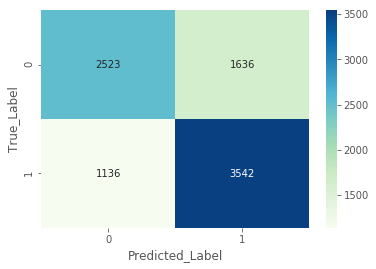

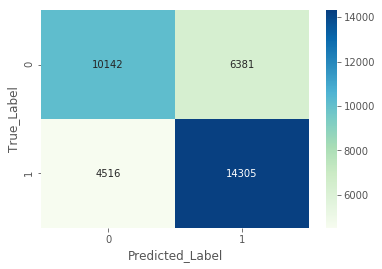

In [153]:
# Confusion Matrics
plot_confusion_matrix(y_test, y_test_pred_rfc)
plot_confusion_matrix(y_train, y_train_pred_rfc)


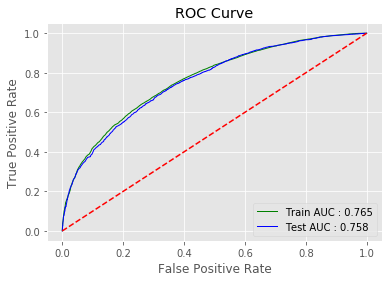

In [154]:
# Plot curves (within sample and out of sample)
plot_roc_curve_train_test(y_train, y_train_proba_rfc, y_test, y_test_proba_rfc)


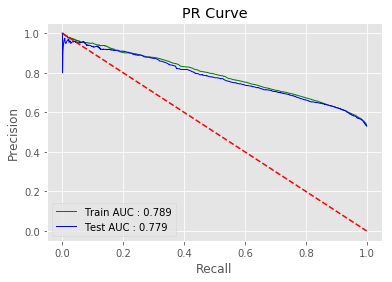

In [155]:
plot_precision_recall_train_test(y_train, y_train_proba_rfc, y_test, y_test_proba_rfc)

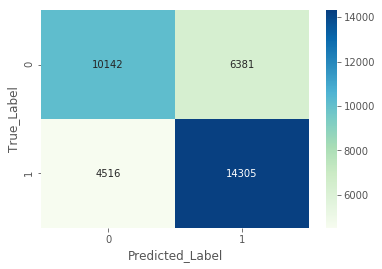

{'precision': 69.153050371898132,
 'recall': 76.005525742117811,
 'fpRate': 38.618894873578533,
 'F1': 72.417546257441927,
 'mcc': 0.37862257954041401,
 'accuracy': 69.168741511800675,
 'blocked_pos': 14305}

In [156]:
# performance evaluation on train dataset
performance_evaluation(y_train,y_train_pred_rfc)

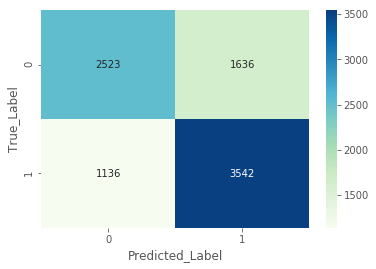

{'precision': 68.404789492692075,
 'recall': 75.716117997526382,
 'fpRate': 39.336378936298715,
 'F1': 71.874999999270742,
 'mcc': 0.3686565214137798,
 'accuracy': 68.6318886492177,
 'blocked_pos': 3542}

In [157]:
# performance evaluation on test dataset
performance_evaluation(y_test,y_test_pred_rfc)

In [158]:
# Feature importance visualization
rfc_index = list(X_train.columns)
feature_importance = pd.DataFrame(model.feature_importances_,index = rfc_index)
feature_importance.reset_index(inplace=True)
feature_importance.columns = ["Feature_name","Feature_importances"]
feature_importance=feature_importance.sort_values(by=['Feature_importances'],ascending=False)
feature_importance

,Feature_name,Feature_importances
3,became_member_year,0.261476
5,difficulty,0.217507
2,income,0.182244
4,reward,0.108592
6,duration,0.099542
7,gender__M,0.059144
1,age,0.034809
9,offer_type__discount,0.022506
0,index,0.011763
8,gender__O,0.002419


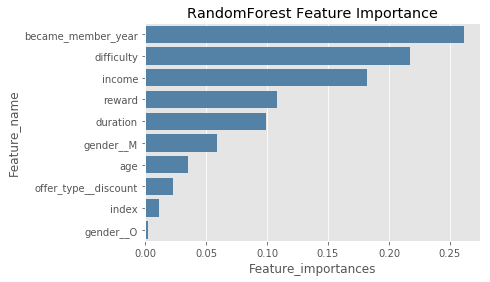

In [159]:
# Visualize feature importance of RandomForest model.
sns.barplot(x=feature_importance.Feature_importances, y=feature_importance.Feature_name, color='steelblue', orient='h')
plt.title("RandomForest Feature Importance")
plt.show()

# Save out AI model

In [160]:
# save classification model: 
algorithm_name = 'RandomForest'
trait_name = 'starbucks_offer'
now_time = datetime.now()
cur_time = "%4d%02d%02d" % (now_time.year, now_time.month, now_time.day)  
with open('%s_%s_%s.pkl'%(trait_name,algorithm_name,cur_time), 'wb') as f:
    pickle.dump(model, f)
print('save pickle file successfully!!!')

save pickle file successfully!!!


# Summary
1. The customers that more completed profiles are more likely to consume starbucks offers.
2. Woman are more likely to consume starbucks offer
3. The customers that became member after 2015 are more likely to consume starbucks offers.
4. Discount offer is more popular offer
5. Based on the exploration with feature importances, difficulty & became_member_year & duration are the top 3 important features.